# Loan Risk Predictor with PySpark
### Predicting if a customer will default on their loan based on the following customer data:

1. Applicant_ID: Unique identifier for each loan applicant.
2. Annual_Income: Annual income of the loan applicant.
3. Applicant_Age: Age of the loan applicant.
4. Work_Experience: Number of years of work experience of the loan applicant.
5. Marital_Status: Marital status of the loan applicant.
6. House_Ownership: Ownership status of the applicant's residence.
7. Vehicle_Ownership(car): Ownership status of the applicant's vehicle.
8. Occupation: Profession or occupation of the loan applicant.
9. Residence_City: City where the loan applicant resides.
10. Residence_State: State where the loan applicant resides.
11. Years_in_Current_Employment: Number of years the applicant has been in their current job.
12. Years_in_Current_Residence: Number of years the applicant has been residing in their current residence.
13. Loan_Default_Risk: Indicator of loan default risk, with values indicating whether the loan applicant is at risk of defaulting on the loan.

The data was obtained from Kaggle datasets: https://www.kaggle.com/datasets/yaminh/applicant-details-for-loan-approve/data

## Set Up 
#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import UnivariateFeatureSelector

#### Start Spark session and import csv file as DataFrame

In [2]:
spark = SparkSession.builder.getOrCreate()

raw_data = spark.read.option('header', True).option('inferSchema', True).csv('Applicant-details.csv')

raw_data.show(3, vertical = True)

print(f' Number of partitions: {raw_data.rdd.getNumPartitions()}')

24/02/28 16:21:14 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.102 instead (on interface en0)
24/02/28 16:21:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/28 16:21:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


-RECORD 0-----------------------------------------
 Applicant_ID                | 75722              
 Annual_Income               | 9657655            
 Applicant_Age               | 76                 
 Work_Experience             | 0                  
 Marital_Status              | single             
 House_Ownership             | rented             
 Vehicle_Ownership(car)      | no                 
 Occupation                  | Psychologist       
 Residence_City              | Jalandhar          
 Residence_State             | Punjab             
 Years_in_Current_Employment | 0                  
 Years_in_Current_Residence  | 12                 
 Loan_Default_Risk           | 0                  
-RECORD 1-----------------------------------------
 Applicant_ID                | 80185              
 Annual_Income               | 9259353            
 Applicant_Age               | 37                 
 Work_Experience             | 18                 
 Marital_Status              | 

## Preliminary EDA
#### Explore the dataset
- Inspect the schema to check they are of the expected dtype
- Explore the summary of the data to get a feel for the data and check for anomalies
- Investigate categorical features to prepare them for plotting

In [3]:
raw_data.printSchema()
raw_data.describe().show(vertical = True)

root
 |-- Applicant_ID: integer (nullable = true)
 |-- Annual_Income: integer (nullable = true)
 |-- Applicant_Age: integer (nullable = true)
 |-- Work_Experience: integer (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- House_Ownership: string (nullable = true)
 |-- Vehicle_Ownership(car): string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Residence_City: string (nullable = true)
 |-- Residence_State: string (nullable = true)
 |-- Years_in_Current_Employment: integer (nullable = true)
 |-- Years_in_Current_Residence: integer (nullable = true)
 |-- Loan_Default_Risk: integer (nullable = true)



24/02/28 16:21:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-------------------------------------------
 summary                     | count                
 Applicant_ID                | 100000               
 Annual_Income               | 100000               
 Applicant_Age               | 100000               
 Work_Experience             | 100000               
 Marital_Status              | 100000               
 House_Ownership             | 100000               
 Vehicle_Ownership(car)      | 100000               
 Occupation                  | 100000               
 Residence_City              | 100000               
 Residence_State             | 100000               
 Years_in_Current_Employment | 100000               
 Years_in_Current_Residence  | 100000               
 Loan_Default_Risk           | 100000               
-RECORD 1-------------------------------------------
 summary                     | mean                 
 Applicant_ID                | 50000.5              
 Annual_Income               | 5001617.02566  

#### Encode some of the categorical data
- To start, I've only used a simple encoding on the features that have a relatively small number of unique values - this is simply so I can visually inspect these to check for anomalies or correlation. The remaining categorical features are encoded later.

In [4]:
# Show the unique values of the categorical variables (I may be able to encode some before visualising the data)
# I would use StringIndexer here but I want to have a specific encoding for each column, so instead I will map 
# these in their RDD form and convert back

for col in raw_data.dtypes:
    if col[1] != 'int':
        raw_data.select(col[0]).distinct().show()

# Mapping function

def col_map(x):
    if x == 'norent_noown' or x == 'single' or x == 'no':
        return 0
    elif x == 'rented' or x == 'married' or x == 'yes':
        return 1
    elif x == 'owned':
        return 2
    else:
        return x

# Convert DataFrame to RDD, apply mapping function, convert back
# NOTE: I drop Residence_City as when encoded it makes the model perform worse - I may add this back in later

data = raw_data.rdd.map(lambda x: (x[0], x[1], x[2], x[3], col_map(x[4]), col_map(x[5]), col_map(x[6]), x[7], 
                                   x[8], x[9], x[10], x[11], x[12])).toDF(raw_data.columns)#\
#                                     .drop('Residence_City').drop('Occupation').drop('Residence_State') #.drop('Applicant_ID')


data.show(3, vertical = True)

+--------------+
|Marital_Status|
+--------------+
|       married|
|        single|
+--------------+

+---------------+
|House_Ownership|
+---------------+
|   norent_noown|
|         rented|
|          owned|
+---------------+

+----------------------+
|Vehicle_Ownership(car)|
+----------------------+
|                    no|
|                   yes|
+----------------------+

+--------------------+
|          Occupation|
+--------------------+
|           Physician|
|           Scientist|
|  Petroleum_Engineer|
|    Technical_writer|
|      Police_officer|
|    Fashion_Designer|
|        Army_officer|
|   Chemical_engineer|
|Chartered_Accountant|
|              Lawyer|
|Air_traffic_contr...|
|                Chef|
|    Flight_attendant|
|Technology_specia...|
|            Designer|
|          Consultant|
|             Drafter|
|        Statistician|
|Computer_hardware...|
|          Magistrate|
+--------------------+
only showing top 20 rows

+----------------+
|  Residence_City|
+--

-RECORD 0-----------------------------------------
 Applicant_ID                | 75722              
 Annual_Income               | 9657655            
 Applicant_Age               | 76                 
 Work_Experience             | 0                  
 Marital_Status              | 0                  
 House_Ownership             | 1                  
 Vehicle_Ownership(car)      | 0                  
 Occupation                  | Psychologist       
 Residence_City              | Jalandhar          
 Residence_State             | Punjab             
 Years_in_Current_Employment | 0                  
 Years_in_Current_Residence  | 12                 
 Loan_Default_Risk           | 0                  
-RECORD 1-----------------------------------------
 Applicant_ID                | 80185              
 Annual_Income               | 9259353            
 Applicant_Age               | 37                 
 Work_Experience             | 18                 
 Marital_Status              | 

#### Display the distribution of the data for visual inspection

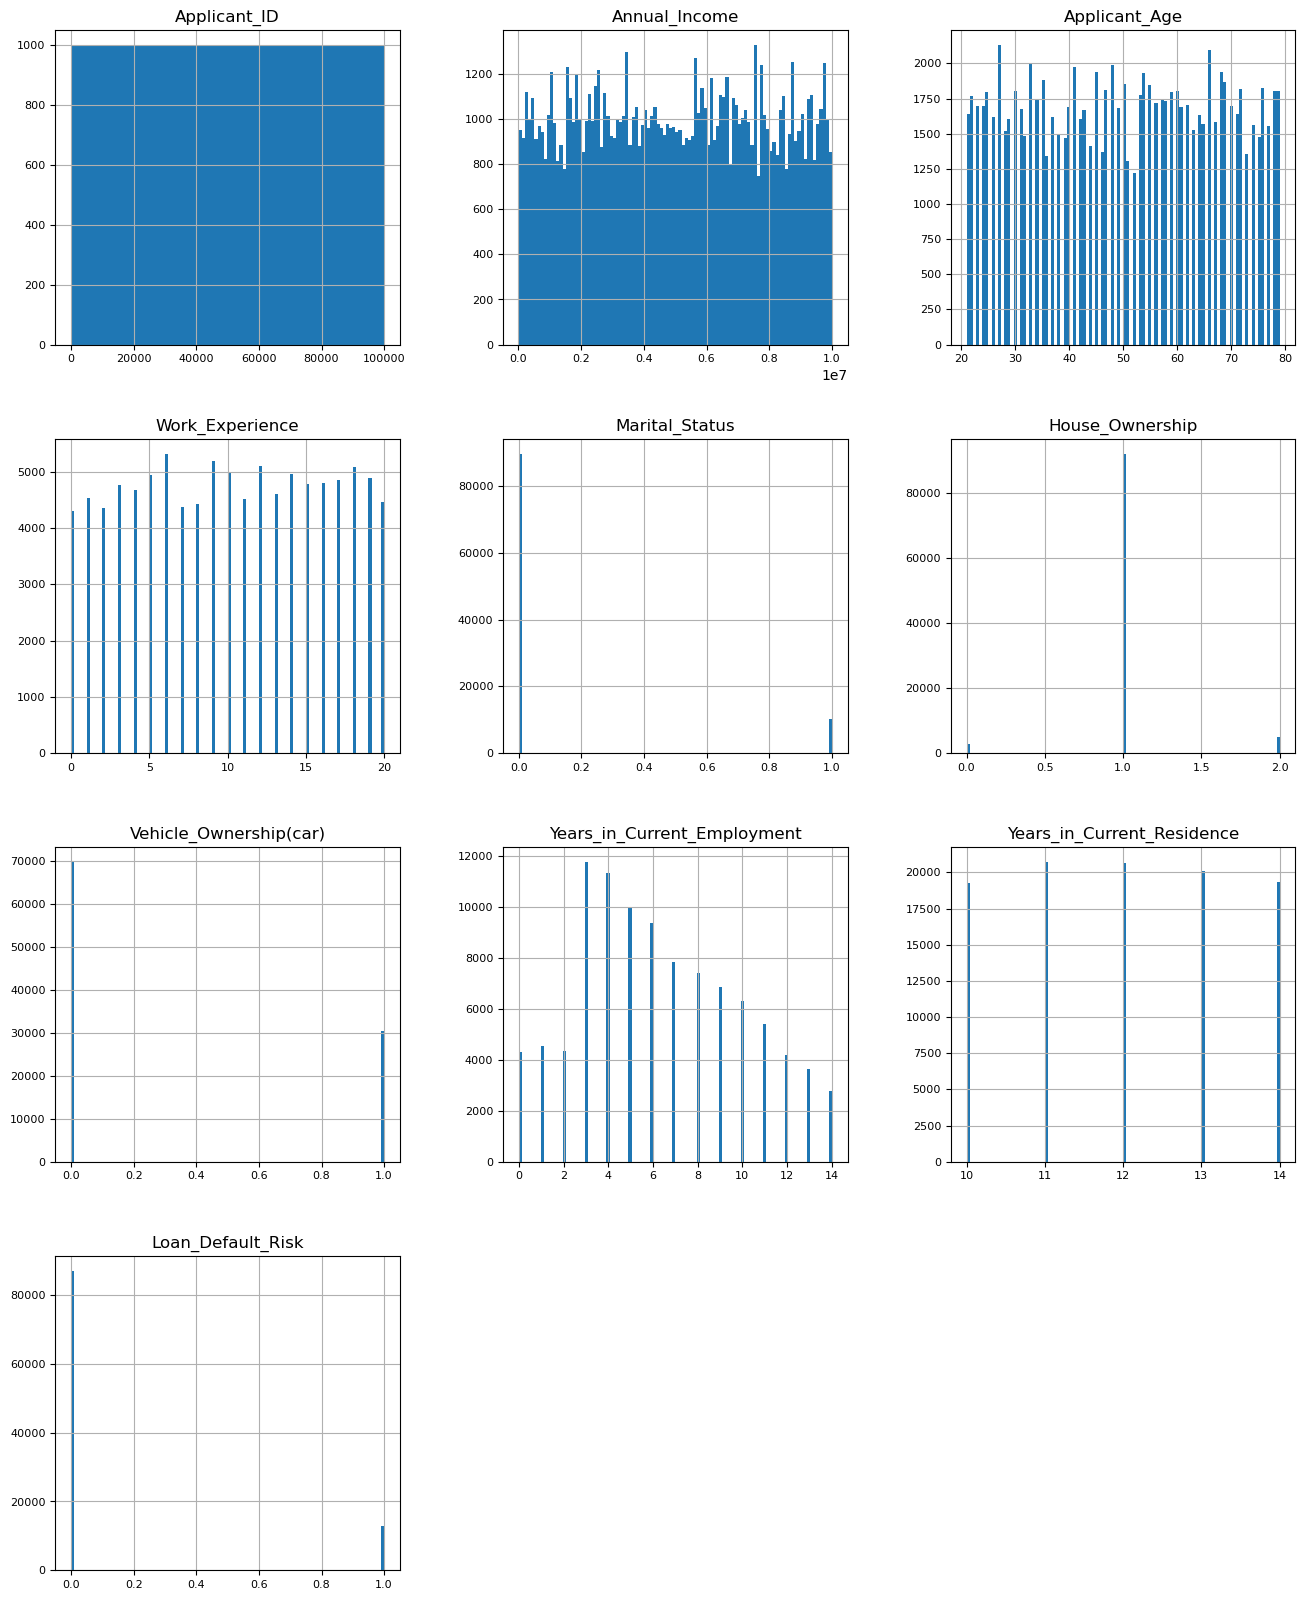

In [5]:
# Split into numerical and categorical features - this will be useful for visualisation and encoding (later)

num_features = [col[0] for col in data.dtypes if col[1] == 'bigint']
cat_features = [col[0] for col in data.dtypes if col[1] == 'string']

num_data = data.select(num_features)
cat_data = data.select(cat_features)

# Plot

num_data.toPandas().hist(figsize=(16, 20),bins=100, xlabelsize=8, ylabelsize=8)
plt.show()

#### Create and plot a correlation matrix to visualise the correlation between variables
- Highly correlated variables will be removed to improve model performance

24/02/28 16:21:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


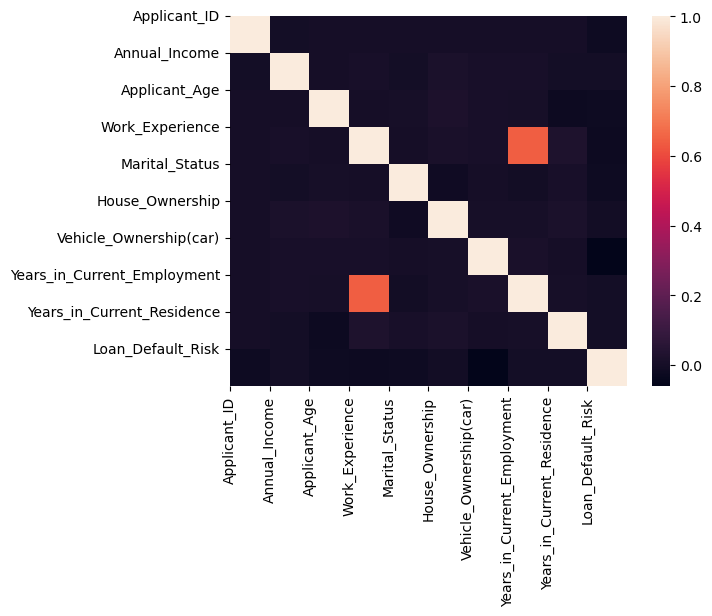

In [6]:
# First create a VectorAssembler to group the numerical data

num_assembler = VectorAssembler(inputCols = num_features, outputCol = 'num_assembled_features')
num_assembled_df = num_assembler.transform(num_data)

# Calculate the correlation

corr_vals = Correlation.corr(num_assembled_df.select('num_assembled_features'), 'num_assembled_features')

corr_mat = corr_vals.collect()[0]['pearson({})'.format('num_assembled_features')].values.reshape(len(num_features),len(num_features))

# Plot

sns.heatmap(corr_mat)
plt.xticks(range(len(num_features)),labels = num_features, rotation = 90)
plt.yticks(range(len(num_features)),labels = num_features, rotation = 0)
plt.show()

# None of the variables are very correlated - no need to remove any

# Remove the target variable from num_features for later on
num_features.remove('Loan_Default_Risk')


## Prepare the data for modelling
#### Split the data into training and test sets

In [7]:
train, test = data.randomSplit([0.7, 0.3], seed = 24)

# I separate the X (features) from the y (labels) as I don't want to scale the label values. For a binary 
# classification this doesn't matter as 0 or 1 will not change, but for regression or classification problems 
# with more than 2 possible outcomes I want to keep the output in the form that makes the most intuitive sense

X_train = train.drop('Loan_Default_Risk')
y_train = train.select('Applicant_ID','Loan_Default_Risk')

X_test = test.drop('Loan_Default_Risk')
y_test = test.select('Applicant_ID','Loan_Default_Risk')

print(f'Training set: {X_train.count()} records')
print(f'Test set: {X_test.count()} records')

Training set: 70075 records


Test set: 29925 records


#### Transform data
- One-Hot encoding for remaining string variables
- Min-Max scaling for numerical data

In [8]:
# Remove Applicant ID from num_features - We do not want to standardize this

num_features.remove('Applicant_ID')

# Create a StringIndexer and a OneHotEncoder to encode the remaining categorical variables

string_indexer = [StringIndexer(inputCol = x, outputCol = f'{x}_si', handleInvalid = 'skip') 
                  for x in cat_features]

one_hot_encoder = [OneHotEncoder(inputCols = [f'{x}_si' for x in cat_features], 
                     outputCols = [f'{x}_ohe' for x in cat_features])]

# Create a VectorAssembler to group the encoded data

assembler_input = num_features + [f'{x}_ohe' for x in cat_features]

vector_assembler = [VectorAssembler(inputCols = assembler_input, outputCol = 'assembled_features')]

# Create a MinMaxScaler to scale the grouped data

scaler = [MinMaxScaler(inputCol = 'assembled_features', outputCol = 'scaled_features')]

In [9]:
# Create a Pipeline to carry out the data preprocessing steps created above

stages = string_indexer + one_hot_encoder + vector_assembler + scaler

pipeline = Pipeline(stages = stages)

# Fit on training data only

preprocess = pipeline.fit(X_train)

# Execute transformation on both train and test data

X_train_scaled = preprocess.transform(X_train)
X_test_scaled = preprocess.transform(X_test)

X_train_scaled.show(5, vertical = True, truncate = False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------
 Applicant_ID                | 1                                                                                                                                        
 Annual_Income               | 1303834                                                                                                                                  
 Applicant_Age               | 23                                                                                                                                       
 Work_Experience             | 3                                                                                                                                        
 Marital_Status              | 0                                                                                                                           

#### Reformat the data in a form that the model will accept

In [10]:
# Reformat the data into DataFrames of just the vectorised features and the labels

train_scaled = X_train_scaled.select('Applicant_ID','scaled_features')\
                                        .join(y_train,
                                              X_train_scaled.Applicant_ID == y_train.Applicant_ID,'inner')\
                                        .drop('Applicant_ID')\
                                        .withColumnRenamed('scaled_features', 'features')\
                                        .withColumnRenamed('Loan_Default_Risk', 'label')


test_scaled = X_test_scaled.select('Applicant_ID','scaled_features')\
                                        .join(y_test, 
                                              X_test_scaled.Applicant_ID == y_test.Applicant_ID,'inner')\
                                        .drop('Applicant_ID')\
                                        .withColumnRenamed('scaled_features', 'features')\
                                        .withColumnRenamed('Loan_Default_Risk', 'label')

#### I use univariate feature selection to reduce the number of features to see if this improves model performance 

In [11]:
# Initialise

selector = UnivariateFeatureSelector(outputCol = 'selected_features').setFeatureType('continuous')\
                                                                        .setLabelType('categorical')\
                                                                        .setSelectionThreshold(200)

# Fit to training data and apply transformation 

feature_model = selector.fit(train_scaled)

train_reduced = feature_model.transform(train_scaled).drop('features')\
                                                      .withColumnRenamed('selected_features', 'features')
test_reduced = feature_model.transform(test_scaled).drop('features')\
                                                    .withColumnRenamed('selected_features', 'features')


## Creating and Refining the Model
#### Create the cross-validation framework for the different model types, here I use Logistic Regression and Random Forest Classification 

In [12]:
# Initialise model

lr = LogisticRegression()

# Generate parameter grid to test

params_lr = ParamGridBuilder().addGrid(lr.regParam,[0.1, 0.2])\
                                .addGrid(lr.elasticNetParam, [0.1, 0.2])\
                                .addGrid(lr.maxIter, [10])\
                                .build()

# Initialise cross-validator

crossval_lr = CrossValidator(estimator = lr,
                             estimatorParamMaps = params_lr, 
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds = 3,
                             seed = 24)

# Train and predict for full data

lr_model = crossval_lr.fit(train_scaled)

lr_results = lr_model.transform(test_scaled)

# Train and predict for reduced features

lr_reduced_model = crossval_lr.fit(train_reduced)

lr_reduced_results = lr_reduced_model.transform(test_reduced)

In [13]:
# Initialise model

rf = RandomForestClassifier(seed = 24)

# Generate parameter grid to test

params_rf = ParamGridBuilder().addGrid(rf.numTrees, [20, 30])\
                                .addGrid(rf.impurity, ['gini', 'entropy'])\
                                .addGrid(rf.minInstancesPerNode, [1, 3])\
                                .build()

# Initialise cross-validator

crossval_rf = CrossValidator(estimator = rf,
                             estimatorParamMaps = params_rf, 
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds = 3,
                             seed = 24)

# Train and predict for full data

rf_model = crossval_rf.fit(train_scaled)

rf_results = rf_model.transform(test_scaled)

# Train and predict for reduced features

rf_reduced_model = crossval_rf.fit(train_reduced)

rf_reduced_results = rf_reduced_model.transform(test_reduced)

#### Evaluating performance

In [14]:
# Here I define F1 score and Accuracy as metrics for model performance

def f1_score(results):
    
    try:
        true_positives = results.filter(results.prediction == 1)\
                                .filter(results.label == 1)\
                                .count()
        false_positives = results.filter(results.prediction == 1)\
                                    .filter(results.label == 0)\
                                    .count()
        false_negatives = results.filter(results.prediction == 0)\
                                    .filter(results.label == 1)\
                                    .count()

        return true_positives/(true_positives + 0.5*(false_positives + false_negatives))
    except:
        print('Error - Input results DataFrame')
        
def accuracy(results):
    
    try:
        true_positives = results.filter(results.prediction == 1)\
                                .filter(results.label == 1)\
                                .count()
        true_negatives = results.filter(results.prediction == 0)\
                                    .filter(results.label == 0)\
                                    .count()
        total = results.count()
        
        return (true_positives + true_negatives)/total
    except:
        print('Error - Input results DataFrame')

In [16]:
# Print Scores
print('Scores')

print('---------------')

print('With All Features:')
print(f'Logistic Regression Accuracy: {accuracy(lr_results)}')
print(f'Logistic Regression F1: {f1_score(lr_results)}')
print(f'Random Forest Accuracy: {accuracy(rf_results)}')
print(f'Random Forest F1: {f1_score(rf_results)}')

print('---------------')

print('With Reduced Features:')
print(f'Logistic Regression Accuracy: {accuracy(lr_reduced_results)}')
print(f'Logistic Regression F1: {f1_score(lr_reduced_results)}')
print(f'Random Forest Accuracy: {accuracy(rf_reduced_results)}')
print(f'Random Forest F1: {f1_score(rf_reduced_results)}')


Scores
---------------
With All Features:


Logistic Regression Accuracy: 0.8702756892230576


Logistic Regression F1: 0.0


Random Forest Accuracy: 0.8702756892230576


Random Forest F1: 0.0
---------------
With Reduced Features:


Logistic Regression Accuracy: 0.8702756892230576


Logistic Regression F1: 0.0


Random Forest Accuracy: 0.8702756892230576


Random Forest F1: 0.0


In [18]:
# Investigation into the predicted results of each model

print('Actual:')
test_scaled.groupBy('label').count().show()

print('Logistic Regression (Whole):')
lr_results.groupBy('prediction').count().show()

print('Logistic Regression (Reduced Features):')
lr_reduced_results.groupBy('prediction').count().show()

print('Random Forest (Whole):')
rf_results.groupBy('prediction').count().show()

print('Random Forest (Reduced Features):')
rf_reduced_results.groupBy('prediction').count().show()

Actual:


+-----+-----+
|label|count|
+-----+-----+
|    0|26043|
|    1| 3882|
+-----+-----+

Logistic Regression (Whole):


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|29925|
+----------+-----+

Logistic Regression (Reduced Features):


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|29925|
+----------+-----+

Random Forest (Whole):


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|29925|
+----------+-----+

Random Forest (Reduced Features):


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|29925|
+----------+-----+



In [19]:
spark.stop()